![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FDev&dt=BQML+Feature+Engineering.ipynb)

# BigQuery ML (BQML) - Advanced Feature Engineering

This notebook will explore preparing data (preprocessing) for machine learning with BigQuery using functions that are part of BigQuery ML (BQML).  

**BigQuery ML (BQML)**

BigQuery Machine Learning allows you to use `SQL` to constuct an ML workflow.  This is a great leap in productivity and flexibility when the data source is BigQuery and users are already familiar with `SQL`. Using just `SQL` multiple techniques can be used for model training and even include hyperparameter tuning.  Predictions can be served directly in BigQuery which also include explainability. Models can be registered to Vertex AI model registry for online predictions on Vertex AI Endpoints.

**If you know:**
```SQL
CREATE TABLE {table name}
    AS
        SELECT ...
        FROM ...
        WHERE ...
```

**Then you are ready to try:**
```SQL
CREATE MODEL {model name} 
    OPTIONS (
        MODEL_TYPE = ...
        {more options}
    )
    AS
        SELECT ...
        FROM ...
        WHERE ...
```

**You can even use:**
- ```SQL
CREATE OR REPLACE MODEL {model name}...
```
- ```SQL
CREATE MODEL IF NOT EXISTS {model name}...
```

**Functions for your ML Workflow**
- Model Evaluation with `ML.EVALUTE`:
    - ```SQL
    SELECT *
    FROM ML.EVALUTE(
        MODEL {model name},
        (
            SELECT ...
            FROM ...
            WHERE ...),
        STRUCT({optional parameters})
    )
    ```
- Prediction Using Models with `ML.PREDICT`:
    - ```SQL
    SELECT *
    FROM ML.PREDICT(
        MODEL {model name},
        (
            SELECT ...
            FROM ...
            WHERE ...),
        STRUCT({optional parameters})
    )
    ```
    
**Feature Engineering**

Feature engineering, or preprocessing, is part of making data ready for machine learning.  BigQuery ML [manual feature preprocessing](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions) functions are available to make this process simple within BigQuery.  

Each `CREATE MODEL ...` statement will do [automatic feature preprocessing](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-auto-preprocessing) by default.  It is also possible include manual feature preprocessing in the `CREATE MODEL ...` statement as a `TRANSFORM` clause where it will also become part of the model serving.  Some of these function even accompany the model when [exported from BigQuery](https://cloud.google.com/bigquery-ml/docs/exporting-models).

```SQL
CREATE MODEL {model name} AS
    TRANSFORM (
        ML.{function name}() OVER() as {name},
        ...
    )
    OPTIONS (
        MODEL_TYPE = ...
        {more options}
    )
    AS
        SELECT ...
        FROM ...
        WHERE ...
```
  
---

**Getting Started**
<p align="center" width="100%">
A great place to start exploring what model types are available and the functions to help create an ML workflow with each model type is this site:
    <center>
        <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey">
            <h1>End-to-end user journey for each model</h1>
        </a>
    </center>
Another great resourse for getting started is the "What is BigQuery ML?" starting page which include a model selection guide.
    <center>
        <a href="https://cloud.google.com/bigquery-ml/docs/introduction">
        <h2>What is BigQuery ML?</h2>
        </a>
    </center>
</p>

---

**Prerequisites:**

None

**Services Used:**
- BigQuery
- Vertex AI
- GCS
- Artifact Registry
- Docker (local to notebook)

**Resources:**
- [BigQuery ML (BQML) Overview](https://cloud.google.com/bigquery-ml/docs/introduction)
- [Overview of BQML methods and workflows](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-e2e-journey)
- [BigQuery](https://cloud.google.com/bigquery)
    - [Documentation:](https://cloud.google.com/bigquery/docs/query-overview)
    - [API:](https://cloud.google.com/bigquery/docs/reference/libraries-overview)
        - [Clients](https://cloud.google.com/bigquery/docs/reference/libraries)
            - [Python SDK:](https://github.com/googleapis/python-bigquery)
            - [Python Library Reference:](https://cloud.google.com/python/docs/reference/bigquery/latest)

---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Dev/BQML%20Feature%20Engineering.ipynb) and run the cells in this section.  Otherwise, skip this section.

In [1]:
try:
    import google.colab
    !pip install --upgrade witwidget -q
    !pip install --upgrade google-cloud-aiplatform -q
    !pip install --upgrade google-cloud-bigquery -q
    !pip install --upgrade google-cloud-bigquery-storage -q
    from google.colab import auth
    auth.authenticate_user()
except Exception:
    pass

In [2]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID
!gcloud config set project {PROJECT_ID}

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey



---
## Environment Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'europe-west4'
EXPERIMENT = 'feature_engineering'
SERIES = '03'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'feature_engineering'
BQ_TABLE = 'bread'

packages:

In [3]:
from google.cloud import aiplatform
from google.cloud import bigquery
from google.cloud import storage

from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import json

from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value

clients:

In [4]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bq = bigquery.Client(project=PROJECT_ID, location = 'EU')
gcs = storage.Client(project = PROJECT_ID)

environment:

In [5]:
DIR = f"temp/{EXPERIMENT}"
!rm -rf {DIR}
!mkdir -p {DIR}

---
## BigQuery Manual Feature Engineering

BigQuery ML [manual feature preprocessing](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions) functions are usefull for converting BigQuery columns to ML features.  BigQuery ML has included a set of these for manual preprocessing and they are individually reviewed here.

These functions can be used directly in BigQuery SQL or within the `TRANSFORM` clause of the `CREATE MODEL` statement.  Using these inside of the `TRANSFORM` clause means they will also be automatically applied during model serving in BigQuery with `ML.PREDICT`.  Some preprocessing statments can also accompany exported models.

**NOTE:** Some of the functions require using calculation over all values in the column and make use of an empty `OVER()` clause.  See `ML.QUANTILE_BUCKETIZE`, `ML.MIN_MAX_SCALER`, `ML.STANDARD_SCALER` for examples. 


### ML.BUCKETIZE

Given a column of numerical values this function creates a new column with bucketed values based on a list of boundaries given as input.
- [Reference](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions#bucketize)
- Is exportabled when used in `TRANFORM` clause

In [6]:
query = f"""
    SELECT
        original_column,
        ML.BUCKETIZE(original_column, [2, 5, 7]) AS bucketed_column
    FROM
        UNNEST([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) as original_column
"""
print(query)


    SELECT
        original_column,
        ML.BUCKETIZE(original_column, [2, 5, 7]) AS bucketed_column
    FROM
        UNNEST([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) as original_column



In [7]:
df = bq.query(query = query).to_dataframe()
df

,original_column,bucketed_column
0,1,bin_1
1,2,bin_2
2,3,bin_2
3,4,bin_2
4,5,bin_3
5,6,bin_3
6,7,bin_4
7,8,bin_4
8,9,bin_4
9,10,bin_4


### ML.POLYNOMIAL_EXPAND

Given a STRUCT of numerical features this returns a STRUCT of polynomial combinations up to the degree passed-in (default = 2).
- [Reference](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions#mlpolynomial_expand)

In [8]:
query = f"""
    SELECT
        col_1, col_2,
        ML.POLYNOMIAL_EXPAND(STRUCT(col_1, col_2)) AS combo_column
    FROM
        UNNEST([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) AS col_1 WITH OFFSET pos1,
        UNNEST([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) AS col_2 WITH OFFSET pos2
    WHERE
        pos1 = pos2
"""
print(query)


    SELECT
        col_1, col_2,
        ML.POLYNOMIAL_EXPAND(STRUCT(col_1, col_2)) AS combo_column
    FROM
        UNNEST([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) AS col_1 WITH OFFSET pos1,
        UNNEST([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) AS col_2 WITH OFFSET pos2
    WHERE
        pos1 = pos2



In [9]:
df = bq.query(query = query).to_dataframe()
df

,col_1,col_2,combo_column
0,1,1,"{'col_1': 1.0, 'col_1_col_1': 1.0, 'col_1_col_..."
1,2,2,"{'col_1': 2.0, 'col_1_col_1': 4.0, 'col_1_col_..."
2,3,3,"{'col_1': 3.0, 'col_1_col_1': 9.0, 'col_1_col_..."
3,4,4,"{'col_1': 4.0, 'col_1_col_1': 16.0, 'col_1_col..."
4,5,5,"{'col_1': 5.0, 'col_1_col_1': 25.0, 'col_1_col..."
5,6,6,"{'col_1': 6.0, 'col_1_col_1': 36.0, 'col_1_col..."
6,7,7,"{'col_1': 7.0, 'col_1_col_1': 49.0, 'col_1_col..."
7,8,8,"{'col_1': 8.0, 'col_1_col_1': 64.0, 'col_1_col..."
8,9,9,"{'col_1': 9.0, 'col_1_col_1': 81.0, 'col_1_col..."
9,10,10,"{'col_1': 10.0, 'col_1_col_1': 100.0, 'col_1_c..."


In [10]:
df['combo_column'].iloc[-1]

{'col_1': 10.0,
 'col_1_col_1': 100.0,
 'col_1_col_2': 100.0,
 'col_2': 10.0,
 'col_2_col_2': 100.0}

### ML.FEATURE_CROSS

Given a STRUCT of categorial features this returns a STRUCT of all combinations up to the degree passed-in (default = 2).
- [Reference](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions#mlfeature_cross)

In [11]:
query = f"""
    SELECT
        col_1, col_2, col_3,
        ML.FEATURE_CROSS(STRUCT(col_1, col_2, col_3)) AS combo_column
    FROM
        UNNEST(['a', 'b', 'c']) as col_1 WITH OFFSET pos1,
        UNNEST(['A', 'B', 'C']) AS col_2 WITH OFFSET pos2,
        UNNEST(['1', '2', '3']) AS col_3 WITH OFFSET pos3
    WHERE
        pos1 = pos2 AND pos2 = pos3
"""
print(query)


    SELECT
        col_1, col_2, col_3,
        ML.FEATURE_CROSS(STRUCT(col_1, col_2, col_3)) AS combo_column
    FROM
        UNNEST(['a', 'b', 'c']) as col_1 WITH OFFSET pos1,
        UNNEST(['A', 'B', 'C']) AS col_2 WITH OFFSET pos2,
        UNNEST(['1', '2', '3']) AS col_3 WITH OFFSET pos3
    WHERE
        pos1 = pos2 AND pos2 = pos3



In [12]:
df = bq.query(query = query).to_dataframe()
df

,col_1,col_2,col_3,combo_column
0,a,A,1,"{'col_1_col_2': 'a_A', 'col_1_col_3': 'a_1', '..."
1,b,B,2,"{'col_1_col_2': 'b_B', 'col_1_col_3': 'b_2', '..."
2,c,C,3,"{'col_1_col_2': 'c_C', 'col_1_col_3': 'c_3', '..."


In [13]:
df['combo_column'].iloc[-1]

{'col_1_col_2': 'c_C', 'col_1_col_3': 'c_3', 'col_2_col_3': 'C_3'}

### ML.NGRAMS

Given an array of strings returns an array of merged inputs strings for the ranges provided.
- [Reference](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions#mlngrams)
- Is exportabled when used in `TRANFORM` clause

In [14]:
query = f"""
    SELECT
        original_column,
        ML.NGRAMS(original_column, [2, 4]) AS ngram_column
    FROM
        (SELECT ['a', 'b', 'c', 'd'] as original_column)
"""
print(query)


    SELECT
        original_column,
        ML.NGRAMS(original_column, [2, 4]) AS ngram_column
    FROM
        (SELECT ['a', 'b', 'c', 'd'] as original_column)



In [15]:
df = bq.query(query = query).to_dataframe()
df

,original_column,ngram_column
0,"[a, b, c, d]","[a b, a b c, a b c d, b c, b c d, c d]"


In [16]:
df.iloc[-1]

original_column                              [a, b, c, d]
ngram_column       [a b, a b c, a b c d, b c, b c d, c d]
Name: 0, dtype: object

### ML.QUANTILE_BUCKATIZE

Given a column of numerical values this function creates a new column with bucketed values named with the value of the quantile based on the input number of buckets.
- [Reference](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions#quantile_bucketize)
- Is exportable when used in `TRANSFORM` clause

In [17]:
query = f"""
    SELECT
        original_column,
        ML.QUANTILE_BUCKETIZE(original_column, 3) OVER() AS bucketed_column
    FROM
        UNNEST([1, 1, 1, 2, 2, 3, 3, 3]) as original_column
    ORDER BY original_column
"""
print(query)


    SELECT
        original_column,
        ML.QUANTILE_BUCKETIZE(original_column, 3) OVER() AS bucketed_column
    FROM
        UNNEST([1, 1, 1, 2, 2, 3, 3, 3]) as original_column
    ORDER BY original_column



In [18]:
df = bq.query(query = query).to_dataframe()
df

,original_column,bucketed_column
0,1,bin_1
1,1,bin_1
2,1,bin_1
3,2,bin_1
4,2,bin_1
5,3,bin_2
6,3,bin_2
7,3,bin_2


### ML.HASH_BUCKATIZE

Given a column of string values this function will hash the values as a new column.  If a bucket size > 0 provided it will take the mod of the hash: remainder of the hash divided by bucket size as the bucket number.
- [Reference](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions#hash_bucketize)
- Is exportabled when used in `TRANFORM` clause

In [19]:
query = f"""
    SELECT
        original_column,
        ML.HASH_BUCKETIZE(original_column, 0) AS hash_column,
        ML.HASH_BUCKETIZE(original_column, 3) AS bucketed_column
    FROM
        UNNEST(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']) as original_column
"""
print(query)


    SELECT
        original_column,
        ML.HASH_BUCKETIZE(original_column, 0) AS hash_column,
        ML.HASH_BUCKETIZE(original_column, 3) AS bucketed_column
    FROM
        UNNEST(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']) as original_column



In [20]:
df = bq.query(query = query).to_dataframe()
df

,original_column,hash_column,bucketed_column
0,a,-5528939962900187677,0
1,b,-6651148003232386794,1
2,c,-7016299626566550744,1
3,d,4470636696479570465,2
4,e,-3078673838733201075,1
5,f,-1522288349254903624,0
6,g,4940667224093463419,2
7,h,-2585402310428948559,1
8,i,-9189916281559197516,1


### ML.MIN_MAX_SCALER

Given a column of numerical value this function will scale the value to the range [0, 1] and cap data at either 0 or 1.  When used with the `TRANSFORM` statement of a `CREATE MODEL` this will also apply to `ML.PREDICT` and cap inputs to 0 or 1.
- [Reference](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions#mlmin_max_scaler)
- Is exportabled when used in `TRANFORM` clause

In [21]:
query = f"""
    SELECT
        original_column,
        ML.MIN_MAX_SCALER(original_column) OVER() AS scale_column
    FROM
        UNNEST([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) as original_column
    ORDER BY original_column
"""
print(query)


    SELECT
        original_column,
        ML.MIN_MAX_SCALER(original_column) OVER() AS scale_column
    FROM
        UNNEST([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) as original_column
    ORDER BY original_column



In [22]:
df = bq.query(query = query).to_dataframe()
df

,original_column,scale_column
0,0,0.0
1,1,0.1
2,2,0.2
3,3,0.3
4,4,0.4
5,5,0.5
6,6,0.6
7,7,0.7
8,8,0.8
9,9,0.9


### ML.STANDARD_SCALER

Given a column of numerical value this function will standardize the values by subtracting the `MEAN` and dividing by the `STDDEV`.  When used with the `TRANSFORM` statement of a `CREATE MODEL` this will also apply to `ML.PREDICT` and use the same values for `MEAN` and `STDDEV`.
- [Reference](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions#mlstandard_scaler)
- Is exportabled when used in `TRANFORM` clause

In [23]:
query = f"""
    SELECT
        original_column,
        ML.STANDARD_SCALER(original_column) OVER() AS scale_column
    FROM
        UNNEST([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) as original_column
    ORDER BY original_column
"""
print(query)


    SELECT
        original_column,
        ML.STANDARD_SCALER(original_column) OVER() AS scale_column
    FROM
        UNNEST([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) as original_column
    ORDER BY original_column



In [24]:
df = bq.query(query = query).to_dataframe()
df

,original_column,scale_column
0,0,-1.507557
1,1,-1.206045
2,2,-0.904534
3,3,-0.603023
4,4,-0.301511
5,5,0.000000
6,6,0.301511
7,7,0.603023
8,8,0.904534
9,9,1.206045


---
## BigQuery Advanced Feature Engineering

Additional BigQuery ML (BQML) manual preprocessing functions for preprocessing data for ML.


### ML.MAX_ABS_SCALER

Given a column of numerical value this function will scale the value to the range [-1, 1] by dividing by the maximum absolute value.
- Reference (coming soon)
- Is exportabled when used in `TRANFORM` clause

In [25]:
query = f"""
    SELECT
        original_column,
        ML.MAX_ABS_SCALER(original_column) OVER() AS scale_column
    FROM
        UNNEST([0, -1, 2, -3, 4, -5, 6, -7, 8, -9, 10]) as original_column
    ORDER BY original_column
"""
print(query)


    SELECT
        original_column,
        ML.MAX_ABS_SCALER(original_column) OVER() AS scale_column
    FROM
        UNNEST([0, -1, 2, -3, 4, -5, 6, -7, 8, -9, 10]) as original_column
    ORDER BY original_column



In [26]:
df = bq.query(query = query).to_dataframe()
df

,original_column,scale_column
0,-9,-0.9
1,-7,-0.7
2,-5,-0.5
3,-3,-0.3
4,-1,-0.1
5,0,0.0
6,2,0.2
7,4,0.4
8,6,0.6
9,8,0.8


### ML.ROBUST_SCALER

Given a column of numerical value this function will scale the values to the quantile range: 
- Specify the quantile range with parameter `quantile_range` which has a default value of `[25, 75]`.
- Centering the data by removing (subtracing) the median with the parameter `with_median` which has default value of `TRUE` the removes median before scaling.
- Scale to the quantile range with parameter `with_quantile_range` which as a default value of `TRUE`.
   
Resources:
- Reference (coming soon)
- Is exportabled when used in `TRANFORM` clause

In [27]:
query = f"""
    SELECT
        original_column,
        ML.ROBUST_SCALER(original_column) OVER() AS scale_column,
        ML.ROBUST_SCALER(original_column, [25, 75], FALSE, TRUE) OVER() AS scale_column2,
        ML.ROBUST_SCALER(original_column, [25, 75], TRUE, FALSE) OVER() AS scale_column3
    FROM
        UNNEST([0, 25, 50, 75, 100]) as original_column
    ORDER BY original_column
"""
print(query)


    SELECT
        original_column,
        ML.ROBUST_SCALER(original_column) OVER() AS scale_column,
        ML.ROBUST_SCALER(original_column, [25, 75], FALSE, TRUE) OVER() AS scale_column2,
        ML.ROBUST_SCALER(original_column, [25, 75], TRUE, FALSE) OVER() AS scale_column3
    FROM
        UNNEST([0, 25, 50, 75, 100]) as original_column
    ORDER BY original_column



In [28]:
df = bq.query(query = query).to_dataframe()
df

,original_column,scale_column,scale_column2,scale_column3
0,0,-1.0,0.0,-50.0
1,25,-0.5,0.5,-25.0
2,50,0.0,1.0,0.0
3,75,0.5,1.5,25.0
4,100,1.0,2.0,50.0


### ML.NORMALIZER

Given a column of numerical arrays this function will normalize the arrays to have unit norm with given p-norm (parameter `p` has default = 2 and takes values 0, +inf, >= 1.
- Reference (coming soon)

In [29]:
query = f"""
    SELECT
        original_column,
        ML.NORMALIZER(original_column) AS norm_2,
        ML.NORMALIZER(original_column, 1) AS norm_1,
        ML.NORMALIZER(original_column, 0) AS norm_0
    FROM
        (SELECT [1, 2, 3, 4, 5] as original_column)
"""
print(query)


    SELECT
        original_column,
        ML.NORMALIZER(original_column) AS norm_2,
        ML.NORMALIZER(original_column, 1) AS norm_1,
        ML.NORMALIZER(original_column, 0) AS norm_0
    FROM
        (SELECT [1, 2, 3, 4, 5] as original_column)



In [30]:
df = bq.query(query = query).to_dataframe()
df

,original_column,norm_2,norm_1,norm_0
0,"[1, 2, 3, 4, 5]","[0.13483997249264842, 0.26967994498529685, 0.4...","[0.06666666666666667, 0.13333333333333333, 0.2...","[0.2, 0.4, 0.6, 0.8, 1.0]"


In [31]:
df['norm_2'].iloc[-1]

array([0.13483997, 0.26967994, 0.40451992, 0.53935989, 0.67419986])

### ML.IMPUTER

Given a column, numerical or categorical (string), the function replaces `NULL` values with the value specified by the paramter `strategy`:
- 'mean' uses the mean (only for numerical columns)
- 'median' uses the median (only for numerical columns)
- 'most_frequent' uses the mode

Reference (coming soon)

In [32]:
query = f"""
    SELECT
        num_column,
        ML.IMPUTER(num_column, 'mean') OVER() AS num_imputed_mean,
        ML.IMPUTER(num_column, 'median') OVER() AS num_imputed_median,
        ML.IMPUTER(num_column, 'most_frequent') OVER() AS num_imputed_mode,
        string_column,
        ML.IMPUTER(string_column, 'most_frequent') OVER() AS string_imputed_mode,
    FROM
        UNNEST([1, 1, 2, 3, 4, 5, NULL]) AS num_column WITH OFFSET pos1,
        UNNEST(['a', 'a', 'b', 'c', 'd', 'e', NULL]) AS string_column WITH OFFSET pos2
    WHERE pos1 = pos2
    ORDER BY num_column
"""
print(query)


    SELECT
        num_column,
        ML.IMPUTER(num_column, 'mean') OVER() AS num_imputed_mean,
        ML.IMPUTER(num_column, 'median') OVER() AS num_imputed_median,
        ML.IMPUTER(num_column, 'most_frequent') OVER() AS num_imputed_mode,
        string_column,
        ML.IMPUTER(string_column, 'most_frequent') OVER() AS string_imputed_mode,
    FROM
        UNNEST([1, 1, 2, 3, 4, 5, NULL]) AS num_column WITH OFFSET pos1,
        UNNEST(['a', 'a', 'b', 'c', 'd', 'e', NULL]) AS string_column WITH OFFSET pos2
    WHERE pos1 = pos2
    ORDER BY num_column



In [33]:
df = bq.query(query = query).to_dataframe()
df

,num_column,num_imputed_mean,num_imputed_median,num_imputed_mode,string_column,string_imputed_mode
0,NaN,2.666667,2.0,1.0,None,a
1,1.0,1.000000,1.0,1.0,a,a
2,1.0,1.000000,1.0,1.0,a,a
3,2.0,2.000000,2.0,2.0,b,b
4,3.0,3.000000,3.0,3.0,c,c
5,4.0,4.000000,4.0,4.0,d,d
6,5.0,5.000000,5.0,5.0,e,e


### ML.ONE_HOT_ENCODER

Given a string column this function will one-hot encode the values in the column after sorting alphabetically.  Any `NULL` or dropped values will be encoded with `0`.
- `drop` takes values 'most_frequent' for dummy encoding or 'none' (default)
- `top_k` takes an integer value that specifies the limit on the number of categories to encode based on frequency (default is 1 million, also the max).
- `frequency_threshold` takes an integer value that specifies that minimum frequency to be encoded (default = 0)

Reference (coming soon)

In [34]:
query = f"""
    SELECT
        original_column,
        ML.ONE_HOT_ENCODER(original_column) OVER() AS OHE_1,
        ML.ONE_HOT_ENCODER(original_column, 'most_frequent') OVER() AS OHE_2,
        ML.ONE_HOT_ENCODER(original_column, 'most_frequent', 3) OVER() AS OHE_3,
        ML.ONE_HOT_ENCODER(original_column, 'most_frequent', 3, 3) OVER() AS OHE_4
    FROM
        UNNEST([NULL, 'a', 'b', 'b', 'c', 'c', 'c', 'd', 'd', 'd', 'd']) AS original_column
    ORDER BY original_column
"""
print(query)


    SELECT
        original_column,
        ML.ONE_HOT_ENCODER(original_column) OVER() AS OHE_1,
        ML.ONE_HOT_ENCODER(original_column, 'most_frequent') OVER() AS OHE_2,
        ML.ONE_HOT_ENCODER(original_column, 'most_frequent', 3) OVER() AS OHE_3,
        ML.ONE_HOT_ENCODER(original_column, 'most_frequent', 3, 3) OVER() AS OHE_4
    FROM
        UNNEST([NULL, 'a', 'b', 'b', 'c', 'c', 'c', 'd', 'd', 'd', 'd']) AS original_column
    ORDER BY original_column



In [35]:
df = bq.query(query = query).to_dataframe()
df

,original_column,OHE_1,OHE_2,OHE_3,OHE_4
0,None,"[{'index': 0, 'value': 1.0}]","[{'index': 0, 'value': 1.0}]","[{'index': 0, 'value': 1.0}]","[{'index': 0, 'value': 1.0}]"
1,a,"[{'index': 1, 'value': 1.0}]","[{'index': 1, 'value': 1.0}]","[{'index': 0, 'value': 1.0}]","[{'index': 0, 'value': 1.0}]"
2,b,"[{'index': 2, 'value': 1.0}]","[{'index': 2, 'value': 1.0}]","[{'index': 1, 'value': 1.0}]","[{'index': 0, 'value': 1.0}]"
3,b,"[{'index': 2, 'value': 1.0}]","[{'index': 2, 'value': 1.0}]","[{'index': 1, 'value': 1.0}]","[{'index': 0, 'value': 1.0}]"
4,c,"[{'index': 3, 'value': 1.0}]","[{'index': 3, 'value': 1.0}]","[{'index': 2, 'value': 1.0}]","[{'index': 1, 'value': 1.0}]"
5,c,"[{'index': 3, 'value': 1.0}]","[{'index': 3, 'value': 1.0}]","[{'index': 2, 'value': 1.0}]","[{'index': 1, 'value': 1.0}]"
6,c,"[{'index': 3, 'value': 1.0}]","[{'index': 3, 'value': 1.0}]","[{'index': 2, 'value': 1.0}]","[{'index': 1, 'value': 1.0}]"
7,d,"[{'index': 4, 'value': 1.0}]","[{'index': 4, 'value': 0.0}]","[{'index': 3, 'value': 0.0}]","[{'index': 2, 'value': 0.0}]"
8,d,"[{'index': 4, 'value': 1.0}]","[{'index': 4, 'value': 0.0}]","[{'index': 3, 'value': 0.0}]","[{'index': 2, 'value': 0.0}]"
9,d,"[{'index': 4, 'value': 1.0}]","[{'index': 4, 'value': 0.0}]","[{'index': 3, 'value': 0.0}]","[{'index': 2, 'value': 0.0}]"


### ML.LABEL_ENCODER

Given a string column the function will encode the value as integers [0, n] representing categories.  Any `NULL` or removed values will be encoded with `0`.
- `top_k` takes an integer value that specifies the limit on the number of categories to encode based on frequency (default is 1 milion, also the max)
- `frequency_threshold` takes an integer value that specifies that minimum frequency to be encoded (default = 0)

Reference (coming soon)

In [36]:
query = f"""
    SELECT
        original_column,
        ML.LABEL_ENCODER(original_column) OVER() AS OHE_1,
        ML.LABEL_ENCODER(original_column, 3) OVER() AS OHE_3,
        ML.LABEL_ENCODER(original_column, 3, 3) OVER() AS OHE_4
    FROM
        UNNEST([NULL, 'a', 'b', 'b', 'c', 'c', 'c', 'd', 'd', 'd', 'd']) AS original_column
    ORDER BY original_column
"""
print(query)


    SELECT
        original_column,
        ML.LABEL_ENCODER(original_column) OVER() AS OHE_1,
        ML.LABEL_ENCODER(original_column, 3) OVER() AS OHE_3,
        ML.LABEL_ENCODER(original_column, 3, 3) OVER() AS OHE_4
    FROM
        UNNEST([NULL, 'a', 'b', 'b', 'c', 'c', 'c', 'd', 'd', 'd', 'd']) AS original_column
    ORDER BY original_column



In [37]:
df = bq.query(query = query).to_dataframe()
df

,original_column,OHE_1,OHE_3,OHE_4
0,None,0,0,0
1,a,1,0,0
2,b,2,1,0
3,b,2,1,0
4,c,3,2,1
5,c,3,2,1
6,c,3,2,1
7,d,4,3,2
8,d,4,3,2
9,d,4,3,2


## Advanced Usage of Manual Feature Engineering

There may be situations where multiple feature preprocessing functions are needed.  Here is an example of using `ML.IMPUTER` with `ML.POLYNOMIAL_EXPAND` for example.

**NOTE:** A analytic function (has `OVER ()`)cannot be an argument of another analytic function, however, scaler function can be arguments.

This Example Compounds:
- `CAST` the string values to `FLOAT64`
- imputes missing values for the column with `ML.IMPUTER`
- uses `ML.POLYNOMIAL_EXPAND` to create higher order terms from the imputed column

In [38]:
query = f"""
SELECT
    original_column,
    ML.POLYNOMIAL_EXPAND(
        STRUCT(
            ML.IMPUTER(
                CAST(original_column AS FLOAT64),
                'mean'
            ) OVER() AS num_imputed_mean
        ),
        2
    ) AS imputed_expanded
FROM
    UNNEST(['1', '1', '2', '3', '4', '5', NULL]) AS original_column
"""
print(query)


SELECT
    original_column,
    ML.POLYNOMIAL_EXPAND(
        STRUCT(
            ML.IMPUTER(
                CAST(original_column AS FLOAT64),
                'mean'
            ) OVER() AS num_imputed_mean
        ),
        2
    ) AS imputed_expanded
FROM
    UNNEST(['1', '1', '2', '3', '4', '5', NULL]) AS original_column



In [39]:
df = bq.query(query = query).to_dataframe()
df

,original_column,imputed_expanded
0,5,"{'num_imputed_mean': 5.0, 'num_imputed_mean_nu..."
1,3,"{'num_imputed_mean': 3.0, 'num_imputed_mean_nu..."
2,4,"{'num_imputed_mean': 4.0, 'num_imputed_mean_nu..."
3,1,"{'num_imputed_mean': 1.0, 'num_imputed_mean_nu..."
4,1,"{'num_imputed_mean': 1.0, 'num_imputed_mean_nu..."
5,None,"{'num_imputed_mean': 2.666666666666667, 'num_i..."
6,2,"{'num_imputed_mean': 2.0, 'num_imputed_mean_nu..."


In [40]:
df['imputed_expanded'].iloc[1]

{'num_imputed_mean': 3.0, 'num_imputed_mean_num_imputed_mean': 9.0}

---
# Data Source: BigQuery

---
## Create BigQuery Dataset

Datasets are like folders, they hold items like tables, models, views.  Datasets are regional resources.

Create the dataset if missing:

In [6]:
ds = bigquery.Dataset(f"{BQ_PROJECT}.{BQ_DATASET}")
ds.location = 'eu' #'us' #REGION
ds.labels = {'experiment': f'{EXPERIMENT}'}
ds = bq.create_dataset(dataset = ds, exists_ok = True)

List BigQuery datasets in the project:

In [7]:
datasets = list(bq.list_datasets())
for d in datasets:
    print(d.dataset_id)

applied_forecasting
explained_columns
feature_engineering
forecasting_8_tournament
fraud
github_api
model_deployment_monitoring_1961322035766362112


Review dataset attributes:

In [8]:
ds.dataset_id

'feature_engineering'

In [9]:
ds.project

'statmike-mlops-349915'

In [10]:
ds.full_dataset_id

'statmike-mlops-349915:feature_engineering'

In [11]:
ds.path

'/projects/statmike-mlops-349915/datasets/feature_engineering'

In [12]:
ds.location

'EU'

---
## Create BigQuery Table

Familiar with the [Great British Bake Off](https://en.wikipedia.org/wiki/The_Great_British_Bake_Off)? Or maybe just familiar with intricate nature of [baking bread](https://en.wikipedia.org/wiki/Bread)?  The code below generates 2000 different bread recipes along with multiple judges ratings of the resulting bread.  These are designed to be a lot like [Ciabatta](https://en.wikipedia.org/wiki/Ciabatta).

This SQL makes heavy use of [GENERATE_ARRAY()](https://cloud.google.com/bigquery/docs/reference/standard-sql/arrays#generating_arrays_of_integers) to create sequences of numbers.  The [RAND() function](https://cloud.google.com/bigquery/docs/reference/standard-sql/mathematical_functions#rand) is the primary mechanism for generating random data but it is uniform `[0, 1)` only. To generate random normal data with MEAN=0 and SD=1 the [Box-Muller Transformation](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform) is implemented in SQL using two `RAND()` values as inputs.  

> Given two random uniform variable, $u_1$ and $u_2$, the following Box-Muller transformation generates two random normal(0, 1) variables:
>
> $\sqrt{-2\ln(u_1)}\sin(2\pi u_2)$ OR $\sqrt{-2\ln(u_1)}\cos(2\pi u_2)$

Expressing these as SQL:
```SQL
# ACOS(-1) = PI
SQRT(-2*LN(RAND()))*SIN(2*ACOS(-1)*RAND())

SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND())
```

**Note** When simulating data with BigQuery and using [CTEs (WITH statement)](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax#with_clause) it is important to note that each CTE will be called once per reference.  That means that using the `RAND()` function could generate different data on each reference.


In [13]:
n = 2000

query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` AS 
WITH
    STEP_1 AS (
        SELECT
            pos as Recipe,
            * EXCEPT(pos)
        FROM (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT 500+10*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS flourAmt)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(8+4*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS saltAmt) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(8+4*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS yeastAmt) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(5+1*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS mix1Time) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(2+3*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS mix1Speed) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(4+4*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS mix2Time) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(4+2*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS mix2Speed) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT 330+20*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS water1Amt) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT 110+20*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS water2Amt) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(40+10*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS waterTemp) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT 100+5*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS proveTime) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(35+10*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS restTime) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(20+10*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS bakeTime) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT 425+15*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS bakeTemp) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT 60+10*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS ambTemp) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT 50+10*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) FROM UNNEST(GENERATE_ARRAY(1, {n}))))) AS ambHumidity) USING(pos)
    ),
    STEP_2 AS (
        SELECT *,
            CASE 
                WHEN flourAmt-500 > 0 THEN 0.3*(flourAmt-500)
                ELSE -0.3*(flourAmt-500)
            END AS A,
            CASE 
                WHEN saltAmt-10 > 0 THEN 2*(saltAmt-10)/2
                ELSE -0.5*(saltAmt-10)/2
            END AS B,
            CASE 
                WHEN yeastAmt-10 > 0 THEN 5*(yeastAmt-10)/2
                ELSE -5*(yeastAmt-10)/2
            END AS C,
            CASE 
                WHEN mix1Time-5 > 0 THEN 2*(mix1Time-5)
                ELSE -2*(mix1Time-5)
            END AS D,
            CASE 
                WHEN mix1Speed-3.5 > 0 THEN 0.1*(mix1Speed-3.5)/1.5
                ELSE -0.1*(mix1Speed-3.5)/1.5
            END AS E,
            CASE 
                WHEN mix2Time-6 > 0 THEN (mix2Time-6)/2
                ELSE -2*(mix2Time-6)
            END AS F,
            CASE 
                WHEN mix2Speed-5 > 0 THEN 2*(mix2Speed-5)
                ELSE -2*(mix2Speed-5)/2
            END AS G,
            CASE 
                WHEN water1Amt-330 > 0 THEN (water1Amt-330)/20
                ELSE -1*(water1Amt-330)/20
            END AS H,
            CASE 
                WHEN water2Amt-110 > 0 THEN 6*(water2Amt-110)/20
                ELSE -6*(water2Amt-110)/20
            END AS I,
            CASE 
                WHEN restTime-40 > 0 THEN 3*(restTime-40)/5
                ELSE -3*(restTime-40)/5
            END AS J,
            CASE 
                WHEN bakeTime-25 > 0 THEN 6*(bakeTime-25)/5
                ELSE -6*(bakeTime-25)/5
            END AS K,
            CASE 
                WHEN bakeTemp-425 > 0 THEN 15*(bakeTemp-425)/15
                ELSE -10*(bakeTemp-425)/15
            END AS L,
            -1*((425-bakeTemp)*(bakeTime-25))/25 AS M
        FROM STEP_1
    ),
    STEP_3 AS (
        SELECT * EXCEPT(A, B, C, D, E, F, G, H, I ,J, K, L, M),
            CASE
                WHEN 100-(0+A+B+C+D+E+F+G+H+I+J+K+L+M)+4 < 0 THEN 0
                WHEN 100-(0+A+B+C+D+E+F+G+H+I+J+K+L+M)+4 > 100 THEN 100
                ELSE ROUND(100-(0+A+B+C+D+E+F+G+H+I+J+K+L+M)+4)
            END AS JUDGE_A,
            CASE
                WHEN 5-26*(90/69)+(90/69)*(100-(0+A+B+C+D+E+F+G+H+I+J+K+L+M)+4)-5 < 0 THEN 0
                WHEN 5-26*(90/69)+(90/69)*(100-(0+A+B+C+D+E+F+G+H+I+J+K+L+M)+4)-5 > 100 THEN 100
                ELSE ROUND(5-26*(90/69)+(90/69)*(100-(0+A+B+C+D+E+F+G+H+I+J+K+L+M)+4)-5)
            END AS JUDGE_B
        FROM STEP_2
    )
SELECT *
FROM STEP_3
"""
print(query)


CREATE OR REPLACE TABLE `statmike-mlops-349915.feature_engineering.bread` AS 
WITH
    STEP_1 AS (
        SELECT
            pos as Recipe,
            * EXCEPT(pos)
        FROM (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT 500+10*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) FROM UNNEST(GENERATE_ARRAY(1, 2000))))) AS flourAmt)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(8+4*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, 2000))))) AS saltAmt) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(8+4*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1, 2000))))) AS yeastAmt) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(5+1*SQRT(-2*LN(RAND()))*COS(2*ACOS(-1)*RAND()) AS INT64) FROM UNNEST(GENERATE_ARRAY(1, 2000))))) AS mix1Time) USING(pos)
        JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM UNNEST(ARRAY((SELECT CAST(2+3*RAND() AS INT64) FROM UNNEST(GENERATE_ARRAY(1

In [14]:
job = bq.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

2.83

In [15]:
job.total_bytes_processed

0

### Check out this table in BigQuery Console:
- Click: https://console.cloud.google.com/bigquery
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and review the dataset and table

In [16]:
print(f"Direct Link To This Project In BigQuery:\nhttps://console.cloud.google.com/bigquery?project={BQ_PROJECT}&ws=!1m5!1m4!4m3!1s{BQ_PROJECT}!2s{BQ_DATASET}!3s{BQ_TABLE}")

Direct Link To This Project In BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!4m3!1sstatmike-mlops-349915!2sfeature_engineering!3sbread


---
## Review Data From BigQuery
Additional SQL queries could be used to review the data.  This section shows moving the table to a Pandas dataframe for local review in Python:

> **Note:** <p>This query only selects one column.  This means BigQuery scans less data as it does not process the other columns.  </p>

In [17]:
query = f"""
    SELECT JUDGE_A, JUDGE_B
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""
df = bq.query(query = query).to_dataframe()

In [18]:
print(query)


    SELECT JUDGE_A, JUDGE_B
    FROM `statmike-mlops-349915.feature_engineering.bread`



In [19]:
df.describe()

,JUDGE_A,JUDGE_B
count,2000.000000,2000.000000
mean,74.873000,63.747000
std,9.525347,12.435043
min,31.000000,7.000000
25%,69.000000,57.000000
50%,76.000000,65.000000
75%,81.000000,72.000000
max,98.000000,93.000000


It looks like Judge A is not as harsh as Judge B!

---
# GOAL: Predicting Judges Ratings

Each row of the BigQuery table has all the parameters of a bread recipe and the rating for the resulting bake by two judges.  The goal of the this ML project is to predict the judges rating from the recipe and understand which parameters of the recipe where most important overall ([global explainability](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-global-explain)) and for each recipe ([local explainability](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict)). BigQuery models include AI Explanation functions to assist with this [explainable AI](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-xai-overview)!

---
# Automatic Feature Engineering

---
## Train Model

Use BigQuery ML to train a linear regression model:
- [Linear Regression](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-glm) with BigQuery ML (BQML)

Without specifying a [TRANFORM](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create#transform) clause in the `CREATE MODEL` statement, BigQuery will apply [automatic preprocessing](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-auto-preprocessing) for feature engineering. This includes [imputation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-auto-preprocessing#imputation) and [feature transformation](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-auto-preprocessing#feature-transform) based on the input columns data type.

In [20]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
RUN_NAME = f'run-{TIMESTAMP}'
BQ_MODEL_AutoFeatureEng = f'{SERIES}_{EXPERIMENT}_auto'

In [21]:
query = f"""
CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_AutoFeatureEng}`
OPTIONS (
        model_type = 'LINEAR_REG',
        input_label_cols = ['JUDGE_A'],
        enable_global_explain = TRUE,
        data_split_method = 'AUTO_SPLIT',
        MODEL_REGISTRY = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = 'bqml_{BQ_MODEL_AutoFeatureEng}',
        VERTEX_AI_MODEL_VERSION_ALIASES = ['{RUN_NAME}', 'auto_feature_engineering']
    ) AS
SELECT * EXCEPT(Recipe, JUDGE_B)
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""
print(query)


CREATE OR REPLACE MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_auto`
OPTIONS (
        model_type = 'LINEAR_REG',
        input_label_cols = ['JUDGE_A'],
        enable_global_explain = TRUE,
        data_split_method = 'AUTO_SPLIT',
        MODEL_REGISTRY = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = 'bqml_03_feature_engineering_auto',
        VERTEX_AI_MODEL_VERSION_ALIASES = ['run-20221205131343', 'auto_feature_engineering']
    ) AS
SELECT * EXCEPT(Recipe, JUDGE_B)
FROM `statmike-mlops-349915.feature_engineering.bread`



In [22]:
job = bq.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

20.126

In [23]:
job.total_bytes_processed

272000

Add labels to the model in BigQuery:

In [24]:
bqml_model_AutoFeatureEng = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_AutoFeatureEng}')
bqml_model_AutoFeatureEng.labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
bqml_model_AutoFeatureEng = bq.update_model(bqml_model_AutoFeatureEng, ['labels'])

### Feature and Training Review

Review the Model Inputs, the feature information before preprocessing, with [ML.FEATURE_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-feature):

In [25]:
query = f"""
    SELECT *
    FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_AutoFeatureEng}`)
"""
print(query)


    SELECT *
    FROM ML.FEATURE_INFO(MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_auto`)



In [26]:
bq.query(query = query).to_dataframe()

,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,flourAmt,464.629137,531.315569,500.006487,499.795479,10.076826,NaN,0,NaN
1,saltAmt,8.000000,12.000000,9.945171,10.000000,1.208649,NaN,0,NaN
2,yeastAmt,8.000000,12.000000,10.019938,10.000000,1.244780,NaN,0,NaN
3,mix1Time,2.000000,8.000000,4.943925,5.000000,1.018211,NaN,0,NaN
4,mix1Speed,2.000000,5.000000,3.505919,4.000000,0.985934,NaN,0,NaN
5,mix2Time,4.000000,8.000000,6.012461,6.000000,1.218557,NaN,0,NaN
6,mix2Speed,4.000000,6.000000,4.982555,5.000000,0.708653,NaN,0,NaN
7,water1Amt,266.353963,406.916937,330.839074,331.736753,20.192361,NaN,0,NaN
8,water2Amt,43.523571,189.515438,110.529152,110.221541,20.662534,NaN,0,NaN
9,waterTemp,40.000000,50.000000,44.871651,45.000000,2.912862,NaN,0,NaN


Review the iterations from training with [ML.TRAINING_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train):

In [27]:
query = f"""
    SELECT *
    FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_AutoFeatureEng}`)
    ORDER BY iteration
"""
print(query)


    SELECT *
    FROM ML.TRAINING_INFO(MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_auto`)
    ORDER BY iteration



In [28]:
bq.query(query = query).to_dataframe()

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,91.180504,88.970813,NaN,3264


### Model Metrics Review

Review the model evaluation statistics with [ML.EVALUATE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate):

In [29]:
query = f"""
    SELECT * FROM ML.EVALUATE(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_AutoFeatureEng}`)
"""
print(query)


    SELECT * FROM ML.EVALUATE(MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_auto`)



In [30]:
bq.query(query = query).to_dataframe()

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,7.451816,88.970813,0.01818,6.155074,0.100082,0.100312


### Global Explainability - What is important to Judges?

Retrieve the influence of each feature on the model with [ML.GLOBAL_EXPLAIN](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-global-explain).  

In [31]:
query = f"""
    SELECT *
    FROM ML.GLOBAL_EXPLAIN (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_AutoFeatureEng}`)
"""
print(query)


    SELECT *
    FROM ML.GLOBAL_EXPLAIN (MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_auto`)



In [32]:
gexplain = bq.query(query = query).to_dataframe()
gexplain

,feature,attribution
0,bakeTemp,2.120217
1,mix2Time,0.908017
2,restTime,0.517025
3,saltAmt,0.513952
4,mix2Speed,0.443616
5,yeastAmt,0.282777
6,ambTemp,0.273988
7,water1Amt,0.269367
8,mix1Time,0.248583
9,water2Amt,0.219746


Plot the attribution:

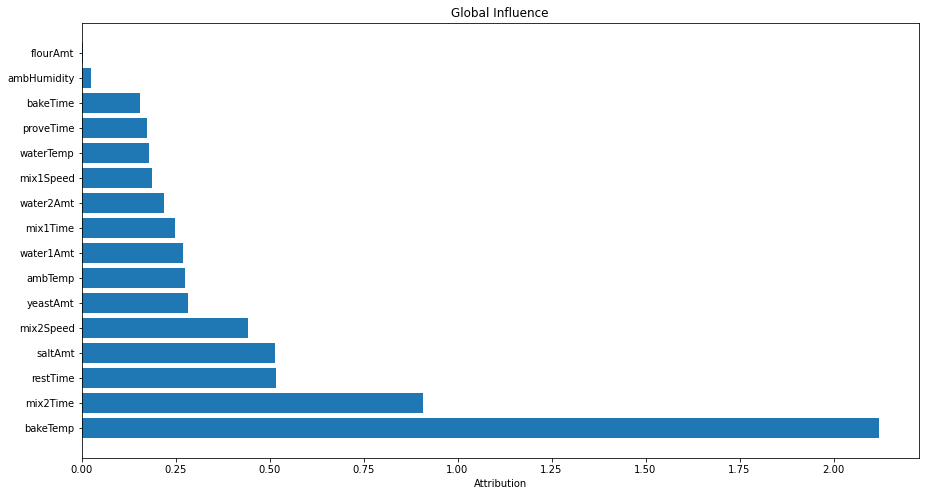

In [33]:
plt.figure(figsize=(15,8))
plt.barh(gexplain['feature'], gexplain['attribution'])
plt.title('Global Influence')
plt.xlabel('Attribution')
#plt.ylabel('Feature')
plt.show()

### Predictions With BigQuery ML (BQML)

Create a pandas dataframe with retrieved predictions for the test data in the table using [ML.PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict):

In [34]:
query = f"""
    SELECT Recipe, JUDGE_A, predicted_JUDGE_A, JUDGE_A-predicted_JUDGE_A as Error
    FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_AutoFeatureEng}`,(
        SELECT *
        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
        WHERE Recipe <= 10)
    )
    ORDER BY Recipe
"""
print(query)


    SELECT Recipe, JUDGE_A, predicted_JUDGE_A, JUDGE_A-predicted_JUDGE_A as Error
    FROM ML.PREDICT (MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_auto`,(
        SELECT *
        FROM `statmike-mlops-349915.feature_engineering.bread`
        WHERE Recipe <= 10)
    )
    ORDER BY Recipe



In [35]:
bq.query(query = query).to_dataframe()

,Recipe,JUDGE_A,predicted_JUDGE_A,Error
0,1,70.0,77.330262,-7.330262
1,2,66.0,72.112146,-6.112146
2,3,79.0,77.073145,1.926855
3,4,74.0,76.504889,-2.504889
4,5,70.0,81.183383,-11.183383
5,6,55.0,72.367368,-17.367368
6,7,46.0,83.202440,-37.202440
7,8,89.0,73.610924,15.389076
8,9,70.0,72.903546,-2.903546
9,10,81.0,73.187578,7.812422


### Local Explainability - What impacted the judges rating?

Retrieve feature attribution values to interpret each features contribution to a prediction relative to the baseline prediction using [ML.EXPLAIN_PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict).

In [36]:
query = f"""
    SELECT *
    FROM ML.EXPLAIN_PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_AutoFeatureEng}`,(
        SELECT *
        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
        WHERE Recipe <= 10)
    )
    ORDER BY Recipe
"""
print(query)


    SELECT *
    FROM ML.EXPLAIN_PREDICT (MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_auto`,(
        SELECT *
        FROM `statmike-mlops-349915.feature_engineering.bread`
        WHERE Recipe <= 10)
    )
    ORDER BY Recipe



In [37]:
explain = bq.query(query = query).to_dataframe()
explain

,predicted_JUDGE_A,top_feature_attributions,baseline_prediction_value,prediction_value,approximation_error,Recipe,flourAmt,saltAmt,yeastAmt,mix1Time,...,water2Amt,waterTemp,proveTime,restTime,bakeTime,bakeTemp,ambTemp,ambHumidity,JUDGE_A,JUDGE_B
0,77.330262,"[{'feature': 'bakeTemp', 'attribution': 2.1317...",74.966942,77.330262,0.0,1,513.590430,11,9,6,...,84.535695,48,96.759429,43,29,410.818440,51.493951,50.678146,70.0,57.0
1,72.112146,"[{'feature': 'bakeTemp', 'attribution': -2.494...",74.966942,72.112146,0.0,2,477.741412,11,10,4,...,119.160448,41,96.987758,38,29,440.651183,60.701619,72.848888,66.0,52.0
2,77.073145,"[{'feature': 'bakeTemp', 'attribution': 2.1874...",74.966942,77.073145,0.0,3,500.380422,8,9,5,...,90.098336,45,110.173959,41,27,410.459549,64.315460,34.450796,79.0,69.0
3,76.504889,"[{'feature': 'bakeTemp', 'attribution': 2.7046...",74.966942,76.504889,0.0,4,509.951109,9,9,5,...,93.738702,40,100.162205,42,27,407.123951,64.440476,58.404141,74.0,63.0
4,81.183383,"[{'feature': 'bakeTemp', 'attribution': 4.5876...",74.966942,81.183383,0.0,5,499.469053,9,10,5,...,99.129879,47,108.672401,36,22,394.980650,54.714489,32.313545,70.0,57.0
5,72.367368,"[{'feature': 'bakeTemp', 'attribution': -4.168...",74.966942,72.367368,0.0,6,482.649864,10,8,6,...,132.374304,47,96.460174,36,23,451.447672,53.755719,36.168577,55.0,38.0
6,83.202440,"[{'feature': 'bakeTemp', 'attribution': 7.7358...",74.966942,83.202440,0.0,7,495.605744,11,10,7,...,134.175038,45,100.765447,44,23,374.678337,55.034972,46.155643,46.0,26.0
7,73.610924,"[{'feature': 'water1Amt', 'attribution': -0.72...",74.966942,73.610924,0.0,8,499.906152,9,9,5,...,99.900899,49,101.701489,42,24,427.659396,68.764859,45.829398,89.0,82.0
8,72.903546,"[{'feature': 'bakeTemp', 'attribution': -1.536...",74.966942,72.903546,0.0,9,489.393923,11,12,5,...,133.695549,41,107.410354,38,29,434.474116,59.836592,49.631292,70.0,57.0
9,73.187578,"[{'feature': 'bakeTemp', 'attribution': -1.250...",74.966942,73.187578,0.0,10,502.710377,9,10,4,...,134.821245,44,102.758140,43,25,432.629145,51.118661,59.671830,81.0,72.0


Create a plot of feature attributions for a single prediction:

In [38]:
recipe = 1
explanation = explain.iloc[recipe-1]['top_feature_attributions']

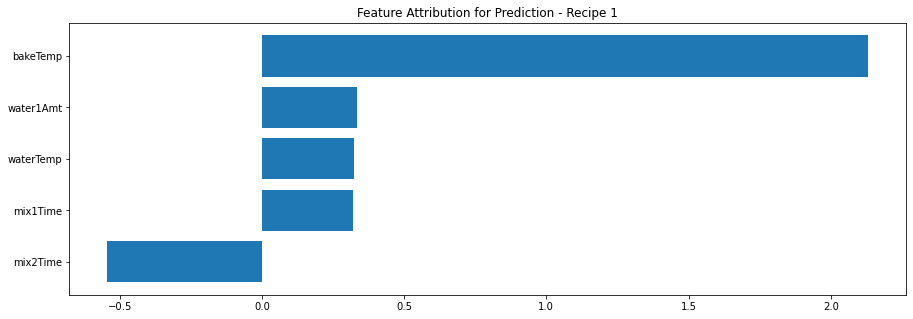

In [39]:
features = []
scores = []
for k in explanation:
    features.append(k['feature'])
    scores.append(k['attribution'])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)

plt.figure(figsize=(15,5))
plt.barh(features, scores)
plt.title(f'Feature Attribution for Prediction - Recipe {recipe}')
plt.show()

### Check out this model in the BigQuery Console:
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and dataset
- Expand Models and select the model create here

In [40]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL_AutoFeatureEng}')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sfeature_engineering!3s03_feature_engineering_auto


### Check out this model in the Vertex AI Console:
- Make sure project selected is the one from this notebook
- Make sure the region is `europe-west4` (default when BQ is `EU` multiregion)

In [41]:
print(f"View the model in the Vertex AI Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/bqml_{BQ_MODEL_AutoFeatureEng}?project={PROJECT_ID}")

View the model in the Vertex AI Console:
https://console.cloud.google.com/vertex-ai/locations/europe-west4/models/bqml_03_feature_engineering_auto?project=statmike-mlops-349915


## Serving

### Vertex AI Model Registry - Get Model

References:
- [aiplatform.Model()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model)

In [42]:
vertex_model_AutoFeatureEng = aiplatform.Model(model_name = f'bqml_{BQ_MODEL_AutoFeatureEng}')
vertex_model_AutoFeatureEng.resource_name

'projects/1026793852137/locations/europe-west4/models/bqml_03_feature_engineering_auto'

In [43]:
evaluation_name = vertex_model_AutoFeatureEng.get_model_evaluation().resource_name
evaluation_name

'projects/1026793852137/locations/europe-west4/models/bqml_03_feature_engineering_auto@1/evaluations/3691278512624238592'

In [44]:
aiplatform.ModelEvaluation(evaluation_name = evaluation_name).to_dict()

{'name': 'projects/1026793852137/locations/europe-west4/models/bqml_03_feature_engineering_auto@1/evaluations/3691278512624238592',
 'metricsSchemaUri': 'gs://google-cloud-aiplatform/schema/modelevaluation/regression_metrics_1.0.0.yaml',
 'metrics': {'rSquared': 0.07817072,
  'rootMeanSquaredLogError': 0.14102152,
  'meanAbsoluteError': 7.477614,
  'rootMeanSquaredError': 9.683413},
 'createTime': '2022-12-05T13:14:06.224768Z'}

In [45]:
vertex_model_AutoFeatureEng.uri

### Vertex AI Endpoint - Create or Retrieve

References:
- [aiplatform.Endpoint()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint)

In [46]:
endpoints = aiplatform.Endpoint.list(filter = f"labels.series={SERIES}")
endpoints = [endpoint for endpoint in endpoints if endpoint.name == f'{SERIES}_AutoFeatureEng']
        
if endpoints:
    endpoint_AutoFeatureEng = endpoint[0]
    print(f"Endpoint Exists: {endpoints[0].resource_name}")
else:
    endpoint_AutoFeatureEng = aiplatform.Endpoint.create(
        display_name = f"{SERIES}_AutoFeatureEng",
        labels = {'series' : f"{SERIES}"}    
    )
    print(f"Endpoint Created: {endpoint_AutoFeatureEng.resource_name}")

print(f'Review the Endpoint in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/endpoints/{endpoint_AutoFeatureEng.name}?project={PROJECT_ID}')  

Creating Endpoint
Create Endpoint backing LRO: projects/1026793852137/locations/europe-west4/endpoints/4375889152781058048/operations/1685466113229455360
Endpoint created. Resource name: projects/1026793852137/locations/europe-west4/endpoints/4375889152781058048
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/1026793852137/locations/europe-west4/endpoints/4375889152781058048')
Endpoint Created: projects/1026793852137/locations/europe-west4/endpoints/4375889152781058048
Review the Endpoint in the Console:
https://console.cloud.google.com/vertex-ai/locations/europe-west4/endpoints/4375889152781058048?project=statmike-mlops-349915


In [47]:
endpoint_AutoFeatureEng.display_name

'03_AutoFeatureEng'

In [48]:
endpoint_AutoFeatureEng.traffic_split

{}

In [49]:
deployed_models = endpoint_AutoFeatureEng.list_models()
#deployed_models

### Deploy Model To Vertex AI Endpoint

In [ ]:
endpoint_AutoFeatureEng.deploy(
    model = vertex_model_AutoFeatureEng,
    deployed_model_display_name = vertex_model_AutoFeatureEng.display_name,
    traffic_percentage = 100,
    machine_type = 'n1-standard-2',
    min_replica_count = 1,
    max_replica_count = 1
)

In [50]:
if (vertex_model_AutoFeatureEng.display_name, vertex_model_AutoFeatureEng.version_id) not in [(deployed_model.display_name, deployed_model.model_version_id) for deployed_model in endpoint_AutoFeatureEng.list_models()]:
    print(f'Deploying model with 100% of traffic...')
    endpoint_AutoFeatureEng.deploy(
        model = vertex_model_AutoFeatureEng,
        deployed_model_display_name = vertex_model_AutoFeatureEng.display_name,
        traffic_percentage = 100,
        machine_type = 'n1-standard-2',
        min_replica_count = 1,
        max_replica_count = 1
    )
else: 
    print(f'The current model/version is already deployed.')

Deploying model with 100% of traffic...
Deploying Model projects/1026793852137/locations/europe-west4/models/bqml_03_feature_engineering_auto to Endpoint : projects/1026793852137/locations/europe-west4/endpoints/4375889152781058048
Deploy Endpoint model backing LRO: projects/1026793852137/locations/europe-west4/endpoints/4375889152781058048/operations/7911692598069166080


InternalServerError: 500 INTERNAL

### Remove Deployed Models without Traffic

In [51]:
for deployed_model in endpoint_AutoFeatureEng.list_models():
    if deployed_model.id in endpoint_AutoFeatureEng.traffic_split:
        print(f"Model {deployed_model.display_name} with version {deployed_model.model_version_id} has traffic = {endpoint_AutoFeatureEng.traffic_split[deployed_model.id]}")
    else:
        endpoint_AutoFeatureEng.undeploy(deployed_model_id = deployed_model.id)
        print(f"Undeploying {deployed_model.display_name} with version {deployed_model.model_version_id} because it has no traffic.")

In [52]:
endpoint_AutoFeatureEng.traffic_split

{}

In [53]:
#endpoint_AutoFeatureEng.list_models()

---
# Manual Feature Engineering

---
## Train Model

Use BigQuery ML to train a linear regression model:
- [Linear Regression](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-glm) with BigQuery ML (BQML)

Feature preprocessing with the `TRANSFORM` statement:
- [TRANSFORM](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create#transform)

In [54]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
RUN_NAME = f'run-{TIMESTAMP}'
BQ_MODEL_ManualFeatureEng = f'{SERIES}_{EXPERIMENT}_manual'

In [55]:
query = f"""
CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_ManualFeatureEng}`
TRANSFORM (
    JUDGE_A,

    ML.MIN_MAX_SCALER(flourAmt) OVER() as scale_flourAmt, 
    ML.ROBUST_SCALER(saltAmt) OVER() as scale_saltAmt,
    ML.MAX_ABS_SCALER(yeastAmt) OVER() as scale_yeastAmt,
    ML.STANDARD_SCALER(water1Amt) OVER() as scale_water1Amt,
    ML.STANDARD_SCALER(water2Amt) OVER() as scale_water2Amt,

    ML.STANDARD_SCALER(waterTemp) OVER() as scale_waterTemp,
    ML.ROBUST_SCALER(bakeTemp) OVER() as scale_bakeTemp,
    ML.MIN_MAX_SCALER(ambTemp) OVER() as scale_ambTemp,
    ML.MAX_ABS_SCALER(ambHumidity) OVER() as scale_ambHumidity,

    ML.ROBUST_SCALER(mix1Time) OVER() as scale_mix1Time,
    ML.ROBUST_SCALER(mix2Time) OVER() as scale_mix2Time,
    ML.ROBUST_SCALER(mix1Speed) OVER() as scale_mix1Speed,
    ML.ROBUST_SCALER(mix2Speed) OVER() as scale_mix2Speed,
    ML.STANDARD_SCALER(proveTime) OVER() as scale_proveTime,
    ML.MAX_ABS_SCALER(restTime) OVER() as scale_restTime,
    ML.MAX_ABS_SCALER(bakeTime) OVER() as scale_bakeTime
)
OPTIONS (
        model_type = 'BOOSTED_TREE_REGRESSOR',
        booster_type = 'GBTREE',
        num_parallel_tree = 1,
        max_iterations = 30,
        early_stop = TRUE,
        min_rel_progress = 0.01,
        tree_method = 'HIST',
        subsample = 0.85,
        #model_type = 'LINEAR_REG',        
        input_label_cols = ['JUDGE_A'],
        enable_global_explain = TRUE,
        data_split_method = 'AUTO_SPLIT',
        l1_reg = 10,
        l2_reg = 10,
        MODEL_REGISTRY = 'VERTEX_AI',
        VERTEX_AI_MODEL_ID = 'bqml_{BQ_MODEL_ManualFeatureEng}',
        VERTEX_AI_MODEL_VERSION_ALIASES = ['{RUN_NAME}', 'manual_feature_engineering']
    ) AS
SELECT * EXCEPT(Recipe, JUDGE_B)
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
"""
print(query)


CREATE OR REPLACE MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_manual`
TRANSFORM (
    JUDGE_A,
    # ML.POLYNOMIAL_EXPAND(STRUCT(flourAmt, saltAmt, yeastAmt, water1Amt, water2Amt), 2) as amounts,
    #ML.POLYNOMIAL_EXPAND(
    #    STRUCT(
            ML.MIN_MAX_SCALER(flourAmt) OVER() as scale_flourAmt, 
            ML.ROBUST_SCALER(saltAmt) OVER() as scale_saltAmt,
            ML.MAX_ABS_SCALER(yeastAmt) OVER() as scale_yeastAmt,
            ML.STANDARD_SCALER(water1Amt) OVER() as scale_water1Amt,
            ML.STANDARD_SCALER(water2Amt) OVER() as scale_water2Amt,
    #    ), 2) as amounts,
    # ML.POLYNOMIAL_EXPAND(STRUCT(waterTemp, bakeTemp, ambTemp, ambHumidity), 2) as temps,
    #ML.POLYNOMIAL_EXPAND(
    #    STRUCT(
            ML.STANDARD_SCALER(waterTemp) OVER() as scale_waterTemp,
            ML.ROBUST_SCALER(bakeTemp) OVER() as scale_bakeTemp,
            ML.MIN_MAX_SCALER(ambTemp) OVER() as scale_ambTemp,
            ML.MAX_ABS_SCALER(ambHumi

In [56]:
job = bq.query(query = query)
job.result()
(job.ended-job.started).total_seconds()

648.939

In [57]:
job.total_bytes_processed

20189351364

Add labels to the model in BigQuery:

In [58]:
bqml_model_ManualFeatureEng = bq.get_model(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_ManualFeatureEng}')
bqml_model_ManualFeatureEng.labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
bqml_model_ManualFeatureEng = bq.update_model(bqml_model_ManualFeatureEng, ['labels'])

### Feature and Training Review

Review the Model Inputs, the feature information before preprocessing, with [ML.FEATURE_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-feature):

In [59]:
query = f"""
    SELECT *
    FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_ManualFeatureEng}`)
"""
print(query)


    SELECT *
    FROM ML.FEATURE_INFO(MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_manual`)



In [60]:
bq.query(query = query).to_dataframe()

,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,saltAmt,8.000000,12.000000,9.945171,10.000000,1.208649,NaN,0,NaN
1,flourAmt,464.629137,531.315569,500.006487,499.769949,10.076826,NaN,0,NaN
2,bakeTemp,376.681348,490.956768,425.259613,425.676923,15.656046,NaN,0,NaN
3,mix2Time,4.000000,8.000000,6.012461,6.000000,1.218557,NaN,0,NaN
4,ambTemp,27.882654,94.063095,60.290996,60.327242,9.944731,NaN,0,NaN
5,restTime,35.000000,45.000000,39.964486,40.000000,2.922202,NaN,0,NaN
6,mix2Speed,4.000000,6.000000,4.982555,5.000000,0.708653,NaN,0,NaN
7,ambHumidity,7.654369,79.164425,50.038947,49.928745,9.920545,NaN,0,NaN
8,proveTime,81.659169,116.994127,100.171586,100.105879,4.886613,NaN,0,NaN
9,bakeTime,20.000000,30.000000,25.018069,25.000000,2.951021,NaN,0,NaN


Review the iterations from training with [ML.TRAINING_INFO](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train):

In [61]:
query = f"""
    SELECT *
    FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_ManualFeatureEng}`)
    ORDER BY iteration
"""
print(query)


    SELECT *
    FROM ML.TRAINING_INFO(MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_manual`)
    ORDER BY iteration



In [62]:
history = bq.query(query = query).to_dataframe()
history

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,1,52.60540,52.71810,0.3,133673
1,0,2,37.43990,37.60450,0.3,111
2,0,3,26.86020,27.10410,0.3,83
3,0,4,19.46730,19.73140,0.3,86
4,0,5,14.31920,14.69030,0.3,79
5,0,6,10.70470,11.12780,0.3,71
6,0,7,8.17919,8.72901,0.3,94
7,0,8,6.44788,7.09096,0.3,15274
8,0,9,5.17890,5.94798,0.3,109
9,0,10,4.34048,5.26313,0.3,87


Plot the loss history:

<AxesSubplot:xlabel='iteration'>

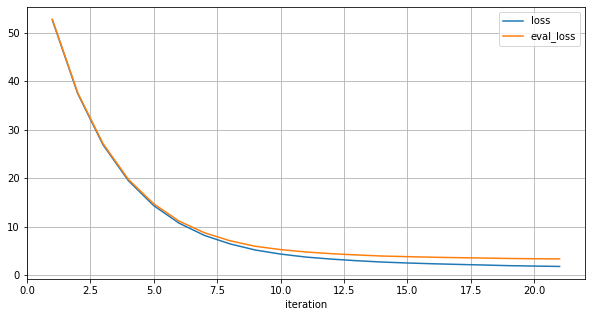

In [63]:
history.plot(x = 'iteration', y = ['loss','eval_loss'], figsize = (10, 5), grid = True)

### Model Metrics Review

Review the model evaluation statistics with [ML.EVALUATE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate):

In [64]:
query = f"""
    SELECT * FROM ML.EVALUATE(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_ManualFeatureEng}`)
"""
print(query)


    SELECT * FROM ML.EVALUATE(MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_manual`)



In [65]:
bq.query(query = query).to_dataframe()

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,2.508818,10.299463,0.002205,2.042549,0.895823,0.895928


### Comparing Metrics Between Automatic and Manual Feature Engineering

The query here loads the metrics with `ML.EVALUATE` for both models.

In [66]:
query = f"""
    SELECT 'Automatic Feature Engineering' as Approach, * FROM ML.EVALUATE(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_AutoFeatureEng}`)
    UNION ALL
    SELECT 'Manual Feature Engineering' as Approach, * FROM ML.EVALUATE(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_ManualFeatureEng}`)
"""
print(query)


    SELECT 'Automatic Feature Engineering' as Approach, * FROM ML.EVALUATE(MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_auto`)
    UNION ALL
    SELECT 'Manual Feature Engineering' as Approach, * FROM ML.EVALUATE(MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_manual`)



In [67]:
bq.query(query = query).to_dataframe()

,Approach,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,Automatic Feature Engineering,7.451816,88.970813,0.018180,6.155074,0.100082,0.100312
1,Manual Feature Engineering,2.508818,10.299463,0.002205,2.042549,0.895823,0.895928


The results show a vast improvement in all metrics.  This is mostly because the relationship between the features and the target was created to have covariance that is best explained by higher order terms.  Fitting the model with a non-linear approach, like a boosted tree (`model_type = BOOSTED_TREE_REGRESSOR`), would also better understand the relationships in these data.

### Feature Importance

Retrieve the [XGBoost feature importances](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor.feature_importances_) for the model using [ML.FEATURE_IMPORTANCE](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-importance).
- importance_weight: the number of splits the feature was used in across all trees
- importance_gain: the improvement in accuracy due to splits using the feature
- importance_cover: the number of rows of data covered by splits using the feature

In [68]:
query = f"""
    SELECT *
    FROM ML.FEATURE_IMPORTANCE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_ManualFeatureEng}`)
    ORDER BY importance_gain DESC
"""
print(query)


    SELECT *
    FROM ML.FEATURE_IMPORTANCE (MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_manual`)
    ORDER BY importance_gain DESC



In [69]:
feature_importance = bq.query(query = query).to_dataframe()
feature_importance

,feature,importance_weight,importance_gain,importance_cover
0,scale_bakeTemp,115,652.362266,315.765217
1,scale_water2Amt,107,206.280381,242.112150
2,scale_bakeTime,59,165.034661,213.728814
3,scale_mix2Time,16,105.665634,345.937500
4,scale_yeastAmt,50,101.207900,236.440000
5,scale_mix1Time,42,72.901849,243.047619
6,scale_mix2Speed,14,68.490817,375.642857
7,scale_flourAmt,102,55.876198,138.686275
8,scale_restTime,34,43.286804,204.852941
9,scale_saltAmt,22,31.772216,128.909091


### Global Explainability - What is important to Judges?

Retrieve the influence of each feature on the model with [ML.GLOBAL_EXPLAIN](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-global-explain).  

In [70]:
query = f"""
    SELECT *
    FROM ML.GLOBAL_EXPLAIN (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_ManualFeatureEng}`)
"""
print(query)


    SELECT *
    FROM ML.GLOBAL_EXPLAIN (MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_manual`)



In [71]:
gexplain = bq.query(query = query).to_dataframe()
gexplain

,feature,attribution
0,scale_bakeTemp,6.233441
1,scale_water2Amt,2.463087
2,scale_bakeTime,1.272877
3,scale_flourAmt,0.921698
4,scale_yeastAmt,0.824206
5,scale_mix2Time,0.634754
6,scale_mix1Time,0.581379
7,scale_restTime,0.342838
8,scale_mix2Speed,0.322986
9,scale_saltAmt,0.176117


Plot the attribution:

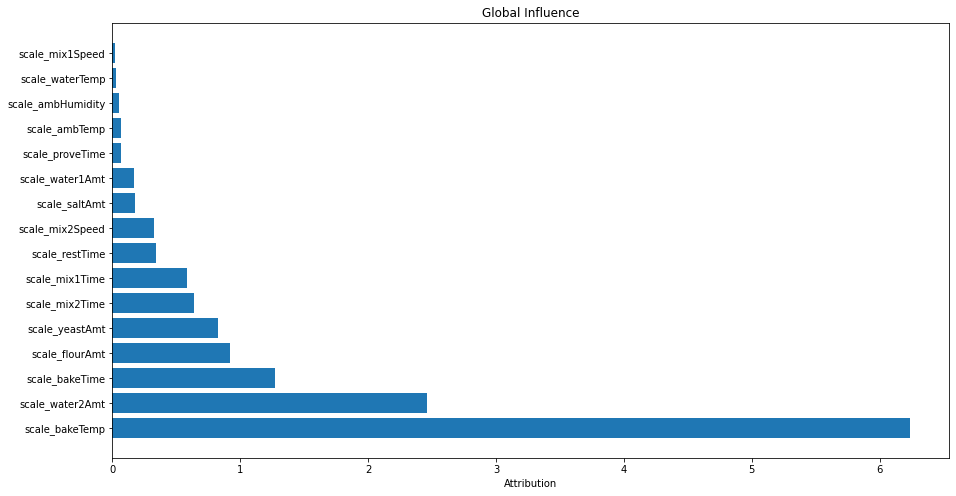

In [72]:
plt.figure(figsize=(15,8))
plt.barh(gexplain['feature'], gexplain['attribution'])
plt.title('Global Influence')
plt.xlabel('Attribution')
#plt.ylabel('Feature')
plt.show()

### Predictions With BigQuery ML (BQML)

Create a pandas dataframe with retrieved predictions for the test data in the table using [ML.PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict):

In [73]:
query = f"""
    SELECT Recipe, JUDGE_A, predicted_JUDGE_A, JUDGE_A-predicted_JUDGE_A as Error
    FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_ManualFeatureEng}`,(
        SELECT *
        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
        WHERE Recipe <= 10)
    )
    ORDER BY Recipe
"""
print(query)


    SELECT Recipe, JUDGE_A, predicted_JUDGE_A, JUDGE_A-predicted_JUDGE_A as Error
    FROM ML.PREDICT (MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_manual`,(
        SELECT *
        FROM `statmike-mlops-349915.feature_engineering.bread`
        WHERE Recipe <= 10)
    )
    ORDER BY Recipe



In [74]:
bq.query(query = query).to_dataframe()

,Recipe,JUDGE_A,predicted_JUDGE_A,Error
0,1,70.0,70.873421,-0.873421
1,2,66.0,68.390388,-2.390388
2,3,79.0,78.842926,0.157074
3,4,74.0,73.354370,0.645630
4,5,70.0,70.936562,-0.936562
5,6,55.0,56.373730,-1.373730
6,7,46.0,64.307907,-18.307907
7,8,89.0,87.634842,1.365158
8,9,70.0,72.136124,-2.136124
9,10,81.0,79.399208,1.600792


### Local Explainability - What impacted the judges rating?

Retrieve feature attribution values to interpret each features contribution to a prediction relative to the baseline prediction using [ML.EXPLAIN_PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict).

In [75]:
query = f"""
    SELECT *
    FROM ML.EXPLAIN_PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_ManualFeatureEng}`,(
        SELECT *
        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
        WHERE Recipe <= 10)
    )
    ORDER BY Recipe
"""
print(query)


    SELECT *
    FROM ML.EXPLAIN_PREDICT (MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_manual`,(
        SELECT *
        FROM `statmike-mlops-349915.feature_engineering.bread`
        WHERE Recipe <= 10)
    )
    ORDER BY Recipe



In [76]:
explain = bq.query(query = query).to_dataframe()
explain

,predicted_JUDGE_A,top_feature_attributions,baseline_prediction_value,prediction_value,approximation_error,Recipe,flourAmt,saltAmt,yeastAmt,mix1Time,...,water2Amt,waterTemp,proveTime,restTime,bakeTime,bakeTemp,ambTemp,ambHumidity,JUDGE_A,JUDGE_B
0,70.873421,"[{'feature': 'scale_water2Amt', 'attribution':...",74.940186,70.873424,0.0,1,513.590430,11,9,6,...,84.535695,48,96.759429,43,29,410.818440,51.493951,50.678146,70.0,57.0
1,68.390388,"[{'feature': 'scale_bakeTemp', 'attribution': ...",74.940186,68.390415,0.0,2,477.741412,11,10,4,...,119.160448,41,96.987758,38,29,440.651183,60.701619,72.848888,66.0,52.0
2,78.842926,"[{'feature': 'scale_bakeTemp', 'attribution': ...",74.940186,78.842932,0.0,3,500.380422,8,9,5,...,90.098336,45,110.173959,41,27,410.459549,64.315460,34.450796,79.0,69.0
3,73.354370,"[{'feature': 'scale_bakeTemp', 'attribution': ...",74.940186,73.354382,0.0,4,509.951109,9,9,5,...,93.738702,40,100.162205,42,27,407.123951,64.440476,58.404141,74.0,63.0
4,70.936562,"[{'feature': 'scale_bakeTemp', 'attribution': ...",74.940186,70.936574,0.0,5,499.469053,9,10,5,...,99.129879,47,108.672401,36,22,394.980650,54.714489,32.313545,70.0,57.0
5,56.373730,"[{'feature': 'scale_bakeTemp', 'attribution': ...",74.940186,56.373752,0.0,6,482.649864,10,8,6,...,132.374304,47,96.460174,36,23,451.447672,53.755719,36.168577,55.0,38.0
6,64.307907,"[{'feature': 'scale_bakeTemp', 'attribution': ...",74.940186,64.307911,0.0,7,495.605744,11,10,7,...,134.175038,45,100.765447,44,23,374.678337,55.034972,46.155643,46.0,26.0
7,87.634842,"[{'feature': 'scale_bakeTemp', 'attribution': ...",74.940186,87.634871,0.0,8,499.906152,9,9,5,...,99.900899,49,101.701489,42,24,427.659396,68.764859,45.829398,89.0,82.0
8,72.136124,"[{'feature': 'scale_bakeTime', 'attribution': ...",74.940186,72.136134,0.0,9,489.393923,11,12,5,...,133.695549,41,107.410354,38,29,434.474116,59.836592,49.631292,70.0,57.0
9,79.399208,"[{'feature': 'scale_bakeTemp', 'attribution': ...",74.940186,79.399234,0.0,10,502.710377,9,10,4,...,134.821245,44,102.758140,43,25,432.629145,51.118661,59.671830,81.0,72.0


Create a plot of feature attributions for a single prediction:

In [77]:
recipe = 1
explanation = explain.iloc[recipe-1]['top_feature_attributions']

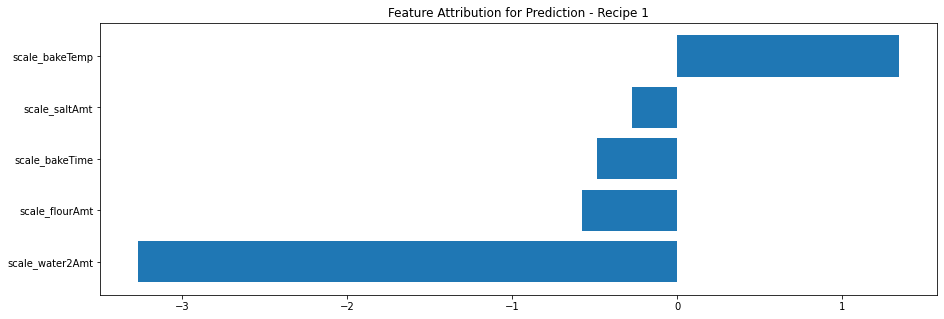

In [78]:
features = []
scores = []
for k in explanation:
    features.append(k['feature'])
    scores.append(k['attribution'])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)

plt.figure(figsize=(15,5))
plt.barh(features, scores)
plt.title(f'Feature Attribution for Prediction - Recipe {recipe}')
plt.show()

### Check out this model in the BigQuery Console:
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and dataset
- Expand Models and select the model create here

### Check out this model in the Vertex AI Console:
- Make sure project selected is the one from this notebook
- Make sure the region is `europe-west4` (default when BQ is `EU` multiregion)

In [79]:
print(f"View the model in the Vertex AI Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/bqml_{BQ_MODEL_ManualFeatureEng}?project={PROJECT_ID}")

View the model in the Vertex AI Console:
https://console.cloud.google.com/vertex-ai/locations/europe-west4/models/bqml_03_feature_engineering_manual?project=statmike-mlops-349915


## Serving

**Notes on Serving With Manual Feature Engineering**

When this model was trained it did register to Vertex AI Model Registry.  At this point in time (November 2022), the resulting model is not directly servable because it is actually 2 models, a preprocessing model that represents the `TRANSFORM` clause, and a model that serves responses from the inputs shaped by the preprocessing.

It is still very possible and advantageous to serve online predictions with Vertex AI.  In this case we can register both models (preprocessing and the model). Serving predictions with these two models could be done in several ways with Vertex AI:
- Create 2 Endpoints: retrieve responses from the preprocessing model to pass to the model
    - Share resources between the endpoints by cohosting them with a [Deployment Resource Pool](https://cloud.google.com/vertex-ai/docs/predictions/model-co-hosting)
- Combine the models in a single serving container with a [Custom Prediction Routine](https://cloud.google.com/vertex-ai/docs/predictions/custom-prediction-routines)

### Vertex AI Model Registry - Get Model

References:
- [aiplatform.Model()](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model)

In [80]:
vertex_model_ManualFeatureEng = aiplatform.Model(model_name = f'bqml_{BQ_MODEL_ManualFeatureEng}')
vertex_model_ManualFeatureEng.resource_name

'projects/1026793852137/locations/europe-west4/models/bqml_03_feature_engineering_manual'

In [81]:
evaluation_name = vertex_model_ManualFeatureEng.get_model_evaluation().resource_name
evaluation_name

'projects/1026793852137/locations/europe-west4/models/bqml_03_feature_engineering_manual@1/evaluations/1869994675817938944'

In [82]:
aiplatform.ModelEvaluation(evaluation_name = evaluation_name).to_dict()

{'name': 'projects/1026793852137/locations/europe-west4/models/bqml_03_feature_engineering_manual@1/evaluations/1869994675817938944',
 'metricsSchemaUri': 'gs://google-cloud-aiplatform/schema/modelevaluation/regression_metrics_1.0.0.yaml',
 'metrics': {'meanAbsoluteError': 2.227757,
  'rSquared': 0.9100735,
  'rootMeanSquaredLogError': 0.047409236,
  'rootMeanSquaredError': 3.0244544},
 'createTime': '2022-12-05T14:25:42.772252Z'}

In [83]:
vertex_model_ManualFeatureEng.uri

### Export Model(s) From BigQuery to GCS

- [Exporting Models](https://cloud.google.com/bigquery-ml/docs/exporting-models)


In [84]:
BUCKET = f'{PROJECT_ID}-{REGION}-bqml-exports'

In [85]:
if not gcs.lookup_bucket(BUCKET):
    bucketDef = gcs.bucket(BUCKET)
    bucketDef = gcs.create_bucket(bucketDef, project=PROJECT_ID, location=REGION)
    print(f'Created Bucket: {gcs.lookup_bucket(BUCKET).name}')
else:
    bucketDef = gcs.bucket(BUCKET)
    print(f'Bucket already exist: {bucketDef.name}')

Created Bucket: statmike-mlops-349915-europe-west4-bqml-exports


In [86]:
print(f'Review the storage bucket in the console here:\nhttps://console.cloud.google.com/storage/browser/{BUCKET};tab=objects&project={PROJECT_ID}')

Review the storage bucket in the console here:
https://console.cloud.google.com/storage/browser/statmike-mlops-349915-europe-west4-bqml-exports;tab=objects&project=statmike-mlops-349915


In [87]:
query = f"""
    EXPORT MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL_ManualFeatureEng}`
        OPTIONS (URI = 'gs://{BUCKET}/{SERIES}/ManualFeatureEng/model')
"""
print(query)


    EXPORT MODEL `statmike-mlops-349915.feature_engineering.03_feature_engineering_manual`
        OPTIONS (URI = 'gs://statmike-mlops-349915-europe-west4-bqml-exports/03/ManualFeatureEng/model')



In [88]:
export = bq.query(query = query)
export.result()
(export.ended - export.started).total_seconds()

44.138

In [89]:
list(bucketDef.list_blobs(prefix = f'{SERIES}/ManualFeatureEng/model'))

[<Blob: statmike-mlops-349915-europe-west4-bqml-exports, 03/ManualFeatureEng/model/, 1670250575932974>,
 <Blob: statmike-mlops-349915-europe-west4-bqml-exports, 03/ManualFeatureEng/model/assets/model_metadata.json, 1670250580608434>,
 <Blob: statmike-mlops-349915-europe-west4-bqml-exports, 03/ManualFeatureEng/model/main.py, 1670250580426529>,
 <Blob: statmike-mlops-349915-europe-west4-bqml-exports, 03/ManualFeatureEng/model/model.bst, 1670250580128280>,
 <Blob: statmike-mlops-349915-europe-west4-bqml-exports, 03/ManualFeatureEng/model/transform/, 1670250576322846>,
 <Blob: statmike-mlops-349915-europe-west4-bqml-exports, 03/ManualFeatureEng/model/transform/assets/, 1670250577540731>,
 <Blob: statmike-mlops-349915-europe-west4-bqml-exports, 03/ManualFeatureEng/model/transform/fingerprint.pb, 1670250577681774>,
 <Blob: statmike-mlops-349915-europe-west4-bqml-exports, 03/ManualFeatureEng/model/transform/keras_metadata.pb, 1670250577799037>,
 <Blob: statmike-mlops-349915-europe-west4-bqml-

Notice the booster file ('.bst') for the model in the main folder as well as a subfolder ('/transfrom') with the TensorFlow saved mode for proprocessing named 'saved_model.pb'.

### Upload Models To Vertex AI Model Registry

Uploading models to Vertex AI Model Registry requires knowing the path the the model save file and a URI for a container that can serve the model.
- Vertex AI Pre-built containers for [prediction and explanation](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers)


#### Register Model

In [90]:
vertex_model_ManualFeatureEng_exportModel = aiplatform.Model.upload(
    display_name = f'{SERIES}_{EXPERIMENT}_manual',
    model_id = f'model_{SERIES}_{EXPERIMENT}_manual',
    serving_container_image_uri = 'us-docker.pkg.dev/vertex-ai/prediction/xgboost-cpu.0-82:latest',
    artifact_uri = f"gs://{BUCKET}/{SERIES}/ManualFeatureEng/model",
    is_default_version = True,
    labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
) 

Creating Model
Create Model backing LRO: projects/1026793852137/locations/europe-west4/models/model_03_feature_engineering_manual/operations/4510746452951040
Model created. Resource name: projects/1026793852137/locations/europe-west4/models/model_03_feature_engineering_manual@1
To use this Model in another session:
model = aiplatform.Model('projects/1026793852137/locations/europe-west4/models/model_03_feature_engineering_manual@1')


In [91]:
vertex_model_ManualFeatureEng_exportModel.display_name

'03_feature_engineering_manual'

In [92]:
vertex_model_ManualFeatureEng_exportModel.name

'model_03_feature_engineering_manual'

In [93]:
vertex_model_ManualFeatureEng_exportModel.resource_name

'projects/1026793852137/locations/europe-west4/models/model_03_feature_engineering_manual'

In [94]:
print(f"View the model in the Vertex AI Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{vertex_model_ManualFeatureEng_exportModel.name}?project={PROJECT_ID}")

View the model in the Vertex AI Console:
https://console.cloud.google.com/vertex-ai/locations/europe-west4/models/model_03_feature_engineering_manual?project=statmike-mlops-349915


#### Register Preprocessing Model

In [95]:
vertex_model_ManualFeatureEng_exportModel_preprocessing = aiplatform.Model.upload(
    display_name = f'{SERIES}_{EXPERIMENT}_manual_preprocessing',
    model_id = f'model_{SERIES}_{EXPERIMENT}_manual_preprocessing',
    serving_container_image_uri = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest',
    artifact_uri = f"gs://{BUCKET}/{SERIES}/ManualFeatureEng/model/transform",
    is_default_version = True,
    labels = {'series' : f'{SERIES}', 'experiment' : f'{EXPERIMENT}'}
) 

Creating Model
Create Model backing LRO: projects/1026793852137/locations/europe-west4/models/model_03_feature_engineering_manual_preprocessing/operations/2463476142997241856
Model created. Resource name: projects/1026793852137/locations/europe-west4/models/model_03_feature_engineering_manual_preprocessing@1
To use this Model in another session:
model = aiplatform.Model('projects/1026793852137/locations/europe-west4/models/model_03_feature_engineering_manual_preprocessing@1')


In [96]:
vertex_model_ManualFeatureEng_exportModel_preprocessing.display_name

'03_feature_engineering_manual_preprocessing'

In [97]:
vertex_model_ManualFeatureEng_exportModel_preprocessing.name

'model_03_feature_engineering_manual_preprocessing'

In [98]:
vertex_model_ManualFeatureEng_exportModel_preprocessing.resource_name

'projects/1026793852137/locations/europe-west4/models/model_03_feature_engineering_manual_preprocessing'

In [99]:
print(f"View the model in the Vertex AI Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{vertex_model_ManualFeatureEng_exportModel_preprocessing.name}?project={PROJECT_ID}")

View the model in the Vertex AI Console:
https://console.cloud.google.com/vertex-ai/locations/europe-west4/models/model_03_feature_engineering_manual_preprocessing?project=statmike-mlops-349915


### Create Endpoints

This example will create two endpoints, one for each model.

#### Endpoint for Model

In [100]:
endpoints = aiplatform.Endpoint.list(filter = f"display_name={SERIES}_{EXPERIMENT}_manual")
if endpoints:
    endpoint_ManualFeatureEng = endpoints[0]
    print(f"Endpoint Exists: {endpoint_ManualFeatureEng.display_name}")
else:
    endpoint_ManualFeatureEng = aiplatform.Endpoint.create(
        display_name = f"{SERIES}_{EXPERIMENT}_manual",
        labels = {'series' : f"{SERIES}"}    
    )
    print(f"Endpoint Created: {endpoint_ManualFeatureEng.display_name}")

print(f'Review the Endpoint in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/endpoints/{endpoint_ManualFeatureEng.name}?project={PROJECT_ID}')

Creating Endpoint
Create Endpoint backing LRO: projects/1026793852137/locations/europe-west4/endpoints/7566408013796343808/operations/1407382030378860544
Endpoint created. Resource name: projects/1026793852137/locations/europe-west4/endpoints/7566408013796343808
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/1026793852137/locations/europe-west4/endpoints/7566408013796343808')
Endpoint Created: 03_feature_engineering_manual
Review the Endpoint in the Console:
https://console.cloud.google.com/vertex-ai/locations/europe-west4/endpoints/7566408013796343808?project=statmike-mlops-349915


#### Endpoint for Preprocessing Model

In [102]:
endpoints = aiplatform.Endpoint.list(filter = f"display_name={SERIES}_{EXPERIMENT}_manual_preprocessing")
if endpoints:
    endpoint_ManualFeatureEng_preprocessing = endpoints[0]
    print(f"Endpoint Exists: {endpoint_ManualFeatureEng_preprocessing.display_name}")
else:
    endpoint_ManualFeatureEng_preprocessing = aiplatform.Endpoint.create(
        display_name = f"{SERIES}_{EXPERIMENT}_manual_preprocessing",
        labels = {'series' : f"{SERIES}"}    
    )
    print(f"Endpoint Created: {endpoint_ManualFeatureEng_preprocessing.display_name}")

print(f'Review the Endpoint in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/endpoints/{endpoint_ManualFeatureEng_preprocessing.name}?project={PROJECT_ID}')

Creating Endpoint
Create Endpoint backing LRO: projects/1026793852137/locations/europe-west4/endpoints/9213881052483813376/operations/6362454326253715456
Endpoint created. Resource name: projects/1026793852137/locations/europe-west4/endpoints/9213881052483813376
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/1026793852137/locations/europe-west4/endpoints/9213881052483813376')
Endpoint Created: 03_feature_engineering_manual_preprocessing
Review the Endpoint in the Console:
https://console.cloud.google.com/vertex-ai/locations/europe-west4/endpoints/9213881052483813376?project=statmike-mlops-349915


### Deploy Models to Endpoints

#### Deploy Model

In [101]:
endpoint_ManualFeatureEng.deploy(
    model = vertex_model_ManualFeatureEng_exportModel,
    deployed_model_display_name = vertex_model_ManualFeatureEng_exportModel.display_name,
    traffic_percentage = 100,
    machine_type = 'n1-standard-2',
    min_replica_count = 1,
    max_replica_count = 1
)

Deploying Model projects/1026793852137/locations/europe-west4/models/model_03_feature_engineering_manual to Endpoint : projects/1026793852137/locations/europe-west4/endpoints/7566408013796343808
Deploy Endpoint model backing LRO: projects/1026793852137/locations/europe-west4/endpoints/7566408013796343808/operations/256699131446165504
Endpoint model deployed. Resource name: projects/1026793852137/locations/europe-west4/endpoints/7566408013796343808


#### Deploy Preprocessing Model

In [103]:
endpoint_ManualFeatureEng_preprocessing.deploy(
    model = vertex_model_ManualFeatureEng_exportModel_preprocessing,
    deployed_model_display_name = vertex_model_ManualFeatureEng_exportModel_preprocessing.display_name,
    traffic_percentage = 100,
    machine_type = 'n1-standard-2',
    min_replica_count = 1,
    max_replica_count = 1
)

Deploying Model projects/1026793852137/locations/europe-west4/models/model_03_feature_engineering_manual_preprocessing to Endpoint : projects/1026793852137/locations/europe-west4/endpoints/9213881052483813376
Deploy Endpoint model backing LRO: projects/1026793852137/locations/europe-west4/endpoints/9213881052483813376/operations/792627487103254528
Endpoint model deployed. Resource name: projects/1026793852137/locations/europe-west4/endpoints/9213881052483813376


---
## Prediction

### Retrieve Records For Prediction

In [105]:
n = 10
pred = bq.query(
    query = f"""
        SELECT * EXCEPT(JUDGE_B)
        FROM {BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}
        WHERE Recipe <= 10
        ORDER BY Recipe
    """
).to_dataframe()

In [106]:
pred

,Recipe,flourAmt,saltAmt,yeastAmt,mix1Time,mix1Speed,mix2Time,mix2Speed,water1Amt,water2Amt,waterTemp,proveTime,restTime,bakeTime,bakeTemp,ambTemp,ambHumidity,JUDGE_A
0,1,513.590430,11,9,6,4,5,5,348.222172,84.535695,48,96.759429,43,29,410.818440,51.493951,50.678146,70.0
1,2,477.741412,11,10,4,4,6,5,361.489756,119.160448,41,96.987758,38,29,440.651183,60.701619,72.848888,66.0
2,3,500.380422,8,9,5,3,5,4,308.293283,90.098336,45,110.173959,41,27,410.459549,64.315460,34.450796,79.0
3,4,509.951109,9,9,5,4,5,6,348.089959,93.738702,40,100.162205,42,27,407.123951,64.440476,58.404141,74.0
4,5,499.469053,9,10,5,5,7,5,329.024862,99.129879,47,108.672401,36,22,394.980650,54.714489,32.313545,70.0
5,6,482.649864,10,8,6,2,6,5,345.912611,132.374304,47,96.460174,36,23,451.447672,53.755719,36.168577,55.0
6,7,495.605744,11,10,7,3,6,4,312.449244,134.175038,45,100.765447,44,23,374.678337,55.034972,46.155643,46.0
7,8,499.906152,9,9,5,2,5,5,290.022706,99.900899,49,101.701489,42,24,427.659396,68.764859,45.829398,89.0
8,9,489.393923,11,12,5,5,6,5,344.628278,133.695549,41,107.410354,38,29,434.474116,59.836592,49.631292,70.0
9,10,502.710377,9,10,4,4,5,5,349.661785,134.821245,44,102.758140,43,25,432.629145,51.118661,59.671830,81.0


Shape as instances: dictionaries of key:value pairs for only features used in model

In [107]:
newobs = pred[pred.columns[~pred.columns.isin(['JUDGE_A', 'Recipe'])]].to_dict(orient='records')

In [108]:
newobs[0]

{'flourAmt': 513.5904302273067,
 'saltAmt': 11,
 'yeastAmt': 9,
 'mix1Time': 6,
 'mix1Speed': 4,
 'mix2Time': 5,
 'mix2Speed': 5,
 'water1Amt': 348.2221723224008,
 'water2Amt': 84.53569498923387,
 'waterTemp': 48,
 'proveTime': 96.75942872578248,
 'restTime': 43,
 'bakeTime': 29,
 'bakeTemp': 410.8184404933839,
 'ambTemp': 51.49395081116636,
 'ambHumidity': 50.678145805482934}

In [109]:
instances = [json_format.ParseDict(newob, Value()) for newob in newobs]

In [110]:
len(instances)

10

### Get Predictions: Python Client

In [161]:
preprocess = endpoint_ManualFeatureEng_preprocessing.predict(instances = instances)
preprocess.predictions[0]

{'tf.math.truediv_7': -0.6580416543260527,
 'tf.math.truediv_3': -1.281483643632888,
 'tf.math.truediv_14': 0.5,
 'tf.math.truediv_4': -0.6750352386482935,
 'tf.math.truediv_12': 0.0,
 'tf.math.truediv_10': 1.0,
 'tf.math.truediv': 0.9666666666666667,
 'tf.math.truediv_8': 0.75,
 'tf.math.truediv_2': 0.7416062756722763,
 'tf.math.truediv_15': 0.5,
 'tf.math.truediv_13': 0.9555555555555556,
 'tf.math.truediv_9': 0.9072581112886737,
 'tf.math.truediv_6': 0.6412357754514998,
 'tf.math.truediv_11': 0.3182428040779078,
 'tf.math.truediv_5': -0.5,
 'tf.math.truediv_1': 1.01463529103213}

In [162]:
preprocess = [
    sorted([(int(i[0].replace('tf.math.truediv_', '').replace('tf.math.truediv', '0')), i[1]) for i in list(p.items())], key = lambda x: x[0])
    #[i[1] for i in list(p.items())]
    for p in preprocess.predictions
]
preprocess[0]

[(0, 0.9666666666666667),
 (1, 1.01463529103213),
 (2, 0.7416062756722763),
 (3, -1.281483643632888),
 (4, -0.6750352386482935),
 (5, -0.5),
 (6, 0.6412357754514998),
 (7, -0.6580416543260527),
 (8, 0.75),
 (9, 0.9072581112886737),
 (10, 1.0),
 (11, 0.3182428040779078),
 (12, 0.0),
 (13, 0.9555555555555556),
 (14, 0.5),
 (15, 0.5)]

In [163]:
preprocess = [[i[1] for i in p] for p in preprocess]
preprocess[0]

[0.9666666666666667,
 1.01463529103213,
 0.7416062756722763,
 -1.281483643632888,
 -0.6750352386482935,
 -0.5,
 0.6412357754514998,
 -0.6580416543260527,
 0.75,
 0.9072581112886737,
 1.0,
 0.3182428040779078,
 0.0,
 0.9555555555555556,
 0.5,
 0.5]

In [164]:
prediction = endpoint_ManualFeatureEng.predict(instances = preprocess)
prediction

Prediction(predictions=[70.92046356201172, 67.4446792602539, 61.31904602050781, 68.30730438232422, 68.15265655517578, 70.41631317138672, 68.07524108886719, 68.72350311279297, 62.25347900390625, 67.8530502319336], deployed_model_id='4026103717659934720', model_version_id='1', model_resource_name='projects/1026793852137/locations/europe-west4/models/model_03_feature_engineering_manual', explanations=None)

In [165]:
prediction.predictions

[70.92046356201172,
 67.4446792602539,
 61.31904602050781,
 68.30730438232422,
 68.15265655517578,
 70.41631317138672,
 68.07524108886719,
 68.72350311279297,
 62.25347900390625,
 67.8530502319336]

---
## Remove Resources
- gcs bucket delete (contains model exports)
- endpoints (need to undeploy any models in use)
- bq_model (delete these first, before the dataset.  This also removes them from Vertex AI)
- bq_dataset

In [167]:
# delete gcs bucket
bucketDef.delete(force = True)

In [168]:
# delete endpoint, use `force` incase models are deployed or undeploy them first
endpoint_AutoFeatureEng.delete(force = True)
endpoint_ManualFeatureEng.delete(force = True)
endpoint_ManualFeatureEng_preprocessing.delete(force = True)

Deleting Endpoint : projects/1026793852137/locations/europe-west4/endpoints/4375889152781058048
Delete Endpoint  backing LRO: projects/1026793852137/locations/europe-west4/operations/1889253996367970304
Endpoint deleted. . Resource name: projects/1026793852137/locations/europe-west4/endpoints/4375889152781058048
Undeploying Endpoint model: projects/1026793852137/locations/europe-west4/endpoints/7566408013796343808
Undeploy Endpoint model backing LRO: projects/1026793852137/locations/europe-west4/endpoints/7566408013796343808/operations/8651422031004303360
Endpoint model undeployed. Resource name: projects/1026793852137/locations/europe-west4/endpoints/7566408013796343808
Deleting Endpoint : projects/1026793852137/locations/europe-west4/endpoints/7566408013796343808
Delete Endpoint  backing LRO: projects/1026793852137/locations/europe-west4/operations/6500940014795358208
Endpoint deleted. . Resource name: projects/1026793852137/locations/europe-west4/endpoints/7566408013796343808
Undepl

In [169]:
# delete models created in BQ with BQML - this also removes them from Vertex AI Model Registry
bq.delete_model(bqml_model_ManualFeatureEng)
bq.delete_model(bqml_model_AutoFeatureEng)

In [170]:
# delete vertexai models
vertex_model_ManualFeatureEng_exportModel_preprocessing.delete()
vertex_model_ManualFeatureEng_exportModel.delete()

Deleting Model : projects/1026793852137/locations/europe-west4/models/model_03_feature_engineering_manual_preprocessing
Delete Model  backing LRO: projects/1026793852137/locations/europe-west4/operations/3483541458596659200
Model deleted. . Resource name: projects/1026793852137/locations/europe-west4/models/model_03_feature_engineering_manual_preprocessing
Deleting Model : projects/1026793852137/locations/europe-west4/models/model_03_feature_engineering_manual
Delete Model  backing LRO: projects/1026793852137/locations/europe-west4/operations/7765338804319158272
Model deleted. . Resource name: projects/1026793852137/locations/europe-west4/models/model_03_feature_engineering_manual


In [171]:
# remove the BQ dataset created for this notebook
bq.delete_dataset(ds, delete_contents = True)